# 導引


1.初始設定-載入資料部分將載入路徑換成你的

2.執行初始設定、前處理-定義函數、配對-定義函數區塊即可開始實作部分

3.三個目標區域的實作部分程式基本一樣，變數名有重疊，注意不要交錯執行覆蓋掉

# 初始設定

## 載入套件

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 載入資料

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/中興_人工智慧/hiroshima_challengedata.csv')  # 替換為你的檔案路徑

# 資料前處理

## 測試

觀察資料

In [ ]:
# 假設我們選擇 (80, 95) 作為要分析的座標
selected_x = 80
selected_y = 95

# 篩選出選定座標的資料
selected_data = df[(df['x'] == selected_x) & (df['y'] == selected_y)]

In [ ]:
#有缺失值 (ex. d=0,t=1)
grouped = selected_data.groupby(['d', 't']).size().reset_index(name='count')
grouped

,d,t,count
0,0,0,5
1,0,2,8
2,0,3,4
3,0,4,3
4,0,5,5
...,...,...,...
3585,74,43,22
3586,74,44,15
3587,74,45,11
3588,74,46,16


缺失值處理

In [ ]:
# 假設你有48個時段的資料，並且需要填充所有的[day, time]組合
days = grouped['d'].unique()
times = np.arange(0, 48)  # 假設有 4 個時段

# 生成所有可能的 [day, time] 組合
all_combinations = pd.MultiIndex.from_product([days, times], names=['d', 't'])
full_df = pd.DataFrame(index=all_combinations).reset_index()
full_df

# 合併原始資料和完整的組合資料
df_full = pd.merge(full_df, grouped, on=['d', 't'], how='left')

# 將缺失的 count 補上為 0
df_full['count'] = df_full['count'].fillna(0)

df_full

,d,t,count
0,0,0,5.0
1,0,1,0.0
2,0,2,8.0
3,0,3,4.0
4,0,4,3.0
...,...,...,...
3595,74,43,22.0
3596,74,44,15.0
3597,74,45,11.0
3598,74,46,16.0


## 定義前處理函數

In [ ]:
# 輸入資料集以及目標座標
# 缺失值補0處理(推測為該時段無人經過)
# 回傳該區塊依照日期與時間分類的人流數
def preprocess(df,selected_x, selected_y):
    # 篩選出選定座標的資料
    selected_data = df[(df['x'] == selected_x) & (df['y'] == selected_y)]

    grouped = selected_data.groupby(['d', 't']).size().reset_index(name='count')

    # 假設你有48個時段的資料，並且需要填充所有的[day, time]組合
    days = grouped['d'].unique()
    times = np.arange(0, 48)  # 假設有 4 個時段

    # 生成所有可能的 [day, time] 組合
    all_combinations = pd.MultiIndex.from_product([days, times], names=['d', 't'])
    full_df = pd.DataFrame(index=all_combinations).reset_index()

    # 合併原始資料和完整的組合資料
    df_full = pd.merge(full_df, grouped, on=['d', 't'], how='left')

    # 將缺失的 count 補上為 0
    df_full['count'] = df_full['count'].fillna(0)

    return df_full

In [ ]:
# 測試
'''
df_80_92 = preprocess(df,80,92)
print(df_80_92)
'''

       d   t  count
0      0   0    7.0
1      0   1    5.0
2      0   2    4.0
3      0   3    2.0
4      0   4    3.0
...   ..  ..    ...
3595  74  43   12.0
3596  74  44   11.0
3597  74  45    7.0
3598  74  46    9.0
3599  74  47    4.0

[3600 rows x 3 columns]


# 配對X,y資料組

## 測試

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# 假設我們選擇 (80, 95) 作為要分析的座標
selected_x = 80
selected_y = 95

# 篩選出選定座標的資料
selected_data = coordinate_count[(coordinate_count['x'] == selected_x) & (coordinate_count['y'] == selected_y)]

# 分割資料為訓練資料和驗證資料
train_data = selected_data[selected_data['d'] < 60]  # 前 60 天作為訓練資料
val_data = selected_data[selected_data['d'] >= 60]   # 後 15 天作為驗證資料

# 顯示訓練資料和驗證資料
print(train_data.head())
print(val_data.head())


# 假設我們將天數 'd' 和時間 't' 作為特徵
X_train = train_data[['d', 't']].values
y_train = train_data['pass_count'].values

X_val = val_data[['d', 't']].values
y_val = val_data['pass_count'].values

# 特徵標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# 建立神經網路模型
model = Sequential([
    Dense(64, input_dim=2, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # 預測人數，因此輸出層使用線性激活函數
])

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# 評估模型
loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}')

# 提取特定座標 (80, 95) 和時間 (d, t) 的資料
X_val = val_data[['d', 't']]  # 特徵欄位
y_val = val_data['pass_count']  # 目標欄位

# 進行預測
y_pred = model.predict(X_val)



# 計算均方誤差 (MSE)
val_loss = mean_squared_error(y_val, y_pred)
print(f'Validation Loss (MSE): {val_loss}')

In [ ]:
# 分割資料為訓練資料和驗證資料
train_data = selected_data[selected_data['d'] < 55]  # 前 55 天作為訓練資料
val_data = selected_data[selected_data['d'] < 60]   # 前 5 天作為驗證資料
test_data = selected_data[selected_data['d'] >= 60]  # 後 15 天作為測試資料

In [ ]:
#用48時段(一天)作為特徵

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler


train_data = df_80_92.copy()

# 設定滯後步數（n_lag），假設我們使用過去24小時的數據來預測未來
n_lag = 48
X_train = []
y_train = []

# 創建滯後特徵，這次只用過去的時段人流數量和預測目標的時段與星期
for i in range(n_lag, len(train_data)):
    # 過去 n_lag 時段的人流數量
    past_pass_count = train_data['count'].iloc[i-n_lag:i].values

    # 使用過去的時段人流數量
    X_train.append(past_pass_count)
    y_train.append(train_data['count'].iloc[i])  # 預測當前時段的人流數量

X_train = np.array(X_train)
y_train = np.array(y_train)

# 重塑為LSTM所需的形狀 [樣本數, 時間步長, 特徵數]
X_train = X_train.reshape(X_train.shape[0], n_lag, 1)

# 標準化特徵資料
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)

# 建立LSTM模型
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
    Dense(1)  # 預測當前時段的人流數量
])

model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 177634016.0000
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1788.6387
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1802.1385
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1728.2357
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1713.0509
Epoch 6/50
103/111 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1725.0126

KeyboardInterrupt: 

In [ ]:
#用48時段(一天) + 時間(轉換為週期) + 星期(0-6) 作為特徵

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

# 假設我們有以下的數據
# 'd' 代表天數, 't' 代表時段（0~23），'pass_count' 代表人流數量
train_data = pd.DataFrame({
    'd': np.random.randint(1, 61, 1000),  # 假設有60天
    't': np.random.randint(0, 24, 1000),  # 假設有24個時段
    'pass_count': np.random.randint(0, 100, 1000)  # 隨機人流數量
})

# 處理星期幾 (0-6) - 假設d代表天數，這裡簡單轉換為對應的星期幾
train_data['weekday'] = train_data['d'] % 7

# 處理時段（時間） - 使用正弦和餘弦轉換
train_data['sin_time'] = np.sin(2 * np.pi * train_data['t'] / 24)
train_data['cos_time'] = np.cos(2 * np.pi * train_data['t'] / 24)

# 設定滯後步數（n_lag），假設我們使用過去24小時的數據來預測未來
n_lag = 24
X_train = []
y_train = []

# 創建滯後特徵，這次只用過去的時段人流數量和預測目標的時段與星期
for i in range(n_lag, len(train_data)):
    # 過去 n_lag 時段的人流數量
    past_pass_count = train_data['pass_count'].iloc[i-n_lag:i].values
    # 預測目標的時段和星期幾
    target_time = train_data['t'].iloc[i]  # 預測時段
    target_weekday = train_data['weekday'].iloc[i]  # 預測星期

    # 使用過去的時段人流數量與目標時段、目標星期作為特徵
    X_train.append(np.concatenate([past_pass_count, [target_time, target_weekday]]))
    y_train.append(train_data['pass_count'].iloc[i])  # 預測當前時段的人流數量

X_train = np.array(X_train)
y_train = np.array(y_train)

# 重塑為LSTM所需的形狀 [樣本數, 時間步長, 特徵數]
X_train = X_train.reshape(X_train.shape[0], n_lag + 2, 1)  # +2 for time and weekday

# 標準化特徵資料
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)

# 建立LSTM模型
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
    Dense(1)  # 預測當前時段的人流數量
])

model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, epochs=50, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3263.7585
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2839.0525
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3176.6028
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3194.3508
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3067.7102
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3016.9482
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3093.9128
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3080.3420
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2995.8433
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3088.6873
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2559.4858
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2826.7332
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1464.9001
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1304.4048
Epoch 15/50


KeyboardInterrupt: 

## 定義X,y資料配對函數

In [ ]:
#輸入dataframe, 開始天數, 結束天數, 時間步長
#特徵：該時段的人流 + 時間(轉換為sin,cos週期) + 星期(one hot編碼 0-6)，共10個
#一筆數據：時間步長 * 特徵數 = 48 * 10
#回傳 X: features, y: targets
def create_X_y_pairs(df_input, start, end, n_lag):

    df = df_input.copy()
    start *= n_lag
    end *= n_lag

    # 計算 weekday
    df['weekday'] = df['d'] % 7

    # 將 weekday 轉為 one-hot 編碼
    weekday_one_hot = pd.get_dummies(df['weekday'], prefix='weekday').astype(int)

    # 處理時段（時間） - 使用正弦和餘弦轉換
    df['sin_time'] = np.sin(2 * np.pi * df['t'] / 48)
    df['cos_time'] = np.cos(2 * np.pi * df['t'] / 48)

    X = []
    y = []

    # 創建滯後特徵
    for i in range(start + n_lag, end):
        # 使用過去 n_lag 時段的人流數量和時間/星期幾特徵
        X.append(np.concatenate([
            df['count'].iloc[i-n_lag:i].values,  # 過去 n_lag 時段的人流數量
            df['sin_time'].iloc[i-n_lag:i].values,   # 過去 n_lag 時段的 sin_time
            df['cos_time'].iloc[i-n_lag:i].values,   # 過去 n_lag 時段的 cos_time
            weekday_one_hot.iloc[i-n_lag:i].values.flatten()  # 加入過去 n_lag 時段的 weekday one-hot 編碼
        ]))
        y.append(df['count'].iloc[i])  # 預測當前時段的人流數量

    X = np.array(X) # [資料數, 時間步*特徵數]
    y = np.array(y)

    return X, y

In [ ]:
#測試
'''
n_lag = 48
X, y = create_X_y_pairs(df_80_92, 0,75,n_lag)
print(X.shape)
print(y.shape)
'''

(3552, 480)
(3552,)


# 實作：80, 92

## 處理資料

In [ ]:
n_lag = 48

#獲取指定區塊的資料
df_80_92 = preprocess(df,80,92)

## 分割資料並建立配對資料
X_train, y_train = create_X_y_pairs(df_80_92, 0, 55, n_lag)
X_val, y_val = create_X_y_pairs(df_80_92, 55-1, 60, n_lag) # 第54天用來做X時間上的銜接，y不會被汙染
X_test, y_test = create_X_y_pairs(df_80_92, 60-1, 75, n_lag) # 第59天用來做X時間上的銜接，y不會被汙染

In [ ]:
X_train.shape

(2592, 480)

## 標準化
    僅處理人流部分、不更動時間與星期

In [ ]:
#train set

# 初始化 scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 對 count 部分標準化
X_count = X_train[:, :n_lag]  # 提取 count 部分
X_count = scaler_X.fit_transform(X_count)  # fit_transform 用於 count

# 替換原始的 count 部分
X_train[:, :n_lag] = X_count

# 對 y_train 使用 fit_transform 進行標準化
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

print(X_train.shape)
print(y_train.shape)

(2592, 480)
(2592,)


In [ ]:
#val set

# 對 count 部分標準化
X_count = X_val[:, :n_lag]  # 提取 count 部分
X_count = scaler_X.transform(X_count)  # transform 用於 count

# 替換原始的 count 部分
X_val[:, :n_lag] = X_count

# 對 y_val 使用 transform 進行標準化
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

print(X_val.shape)
print(y_val.shape)

(240, 480)
(240,)


In [ ]:
# test set

# 對 count 部分標準化
X_count = X_test[:, :n_lag]  # 提取 count 部分
X_count = scaler_X.transform(X_count)  # transform 用於 count

# 替換原始的 count 部分
X_test[:, :n_lag] = X_count

# 對 y_test 使用 transform 進行標準化
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(X_test.shape)
print(y_test.shape)

(720, 480)
(720,)


## 訓練

In [ ]:
# 重塑為LSTM所需的形狀 [樣本數, 時間步長, 特徵數]
X_train = X_train.reshape(X_train.shape[0], n_lag, 10)
X_val = X_val.reshape(X_val.shape[0], n_lag, 10)
X_test = X_test.reshape(X_test.shape[0], n_lag, 10)

# 建立LSTM模型
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])), # 默認激活為 tanh
    Dense(1)  # 預測當前時段的人流數量
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# 訓練模型並獲得訓練過程的歷史資料
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# 評估模型
loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.0036 - mean_absolute_error: 0.8916 - val_loss: 0.9201 - val_mean_absolute_error: 0.8652
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0106 - mean_absolute_error: 0.8927 - val_loss: 0.9080 - val_mean_absolute_error: 0.8605
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9146 - mean_absolute_error: 0.8248 - val_loss: 0.3179 - val_mean_absolute_error: 0.3907
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2976 - mean_absolute_error: 0.3845 - val_loss: 0.1938 - val_mean_absolute_error: 0.3186
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2306 - mean_absolute_error: 0.3399 - val_loss: 0.1807 - val_mean_absolute_error: 0.3180
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1886 - mean_absolute_error: 0.3160 - val_loss: 0.1348 - val_mean_absolute_error: 0.2821
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1687 - mean_absolute_error: 0.2959 - val_loss: 0.106

## 預測

In [ ]:
# 進行預測
y_pred = model.predict(X_test).flatten()  # 將預測結果轉為一維數組

# 計算均方誤差 (MSE)
test_loss = mean_squared_error(y_test, y_pred)
print(f'Prediction Loss: {test_loss}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Prediction Loss: 0.06923503653939839


## 視覺化分析

In [ ]:
# 提取訓練和驗證損失
train_loss = history.history['loss']
val_loss = history.history['val_loss']

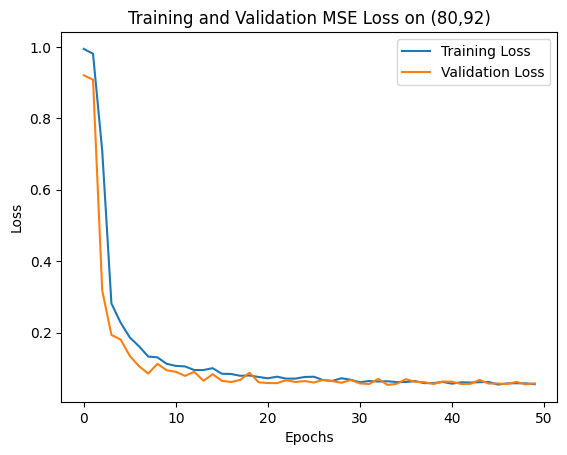

In [ ]:
# 繪製訓練和驗證損失曲線
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation MSE Loss on (80,92)')
plt.show()


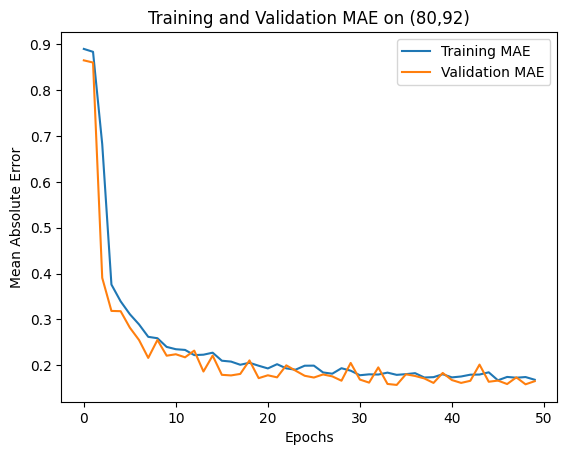

In [ ]:
# 繪製 MAE (Mean Absolute Error) 或 R2 等指標
train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE on (80,92)')
plt.show()


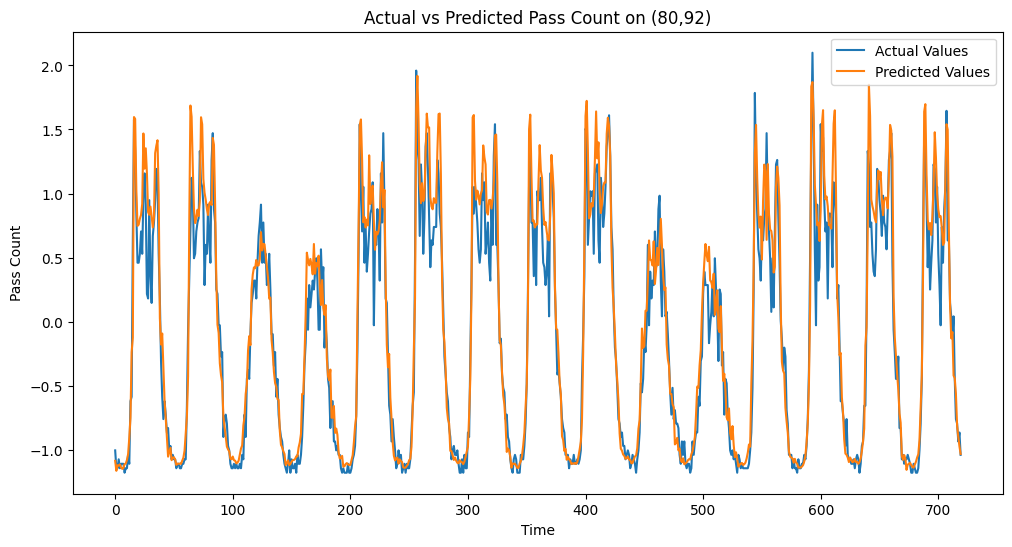

In [ ]:
# 調整圖片大小
plt.figure(figsize=(12, 6))

# 繪製預測值與實際值的比較
plt.plot(y_test, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Pass Count')
plt.legend()
plt.title('Actual vs Predicted Pass Count on (80,92)')
plt.show()


# 實作：80, 93

## 處理資料

In [ ]:
n_lag = 48

#獲取指定區塊的資料
df_80_93 = preprocess(df,80,93)

## 分割資料並建立配對資料
X_train, y_train = create_X_y_pairs(df_80_93, 0, 55, n_lag)
X_val, y_val = create_X_y_pairs(df_80_93, 55-1, 60, n_lag) # 第54天用來做X時間上的銜接，y不會被汙染
X_test, y_test = create_X_y_pairs(df_80_93, 60-1, 75, n_lag) # 第59天用來做X時間上的銜接，y不會被汙染

In [ ]:
X_train.shape

(2592, 480)

## 標準化
    僅處理人流部分、不更動時間與星期

In [ ]:
#train set

# 初始化 scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 對 count 部分標準化
X_count = X_train[:, :n_lag]  # 提取 count 部分
X_count = scaler_X.fit_transform(X_count)  # fit_transform 用於 count

# 替換原始的 count 部分
X_train[:, :n_lag] = X_count

# 對 y_train 使用 fit_transform 進行標準化
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

print(X_train.shape)
print(y_train.shape)

(2592, 480)
(2592,)


In [ ]:
#val set

# 對 count 部分標準化
X_count = X_val[:, :n_lag]  # 提取 count 部分
X_count = scaler_X.transform(X_count)  # transform 用於 count

# 替換原始的 count 部分
X_val[:, :n_lag] = X_count

# 對 y_val 使用 transform 進行標準化
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

print(X_val.shape)
print(y_val.shape)

(240, 480)
(240,)


In [ ]:
# test set

# 對 count 部分標準化
X_count = X_test[:, :n_lag]  # 提取 count 部分
X_count = scaler_X.transform(X_count)  # transform 用於 count

# 替換原始的 count 部分
X_test[:, :n_lag] = X_count

# 對 y_test 使用 transform 進行標準化
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(X_test.shape)
print(y_test.shape)

(720, 480)
(720,)


## 訓練

In [ ]:
# 重塑為LSTM所需的形狀 [樣本數, 時間步長, 特徵數]
X_train = X_train.reshape(X_train.shape[0], n_lag, 10)
X_val = X_val.reshape(X_val.shape[0], n_lag, 10)
X_test = X_test.reshape(X_test.shape[0], n_lag, 10)

# 建立LSTM模型
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])), # 默認激活為 tanh
    Dense(1)  # 預測當前時段的人流數量
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# 訓練模型並獲得訓練過程的歷史資料
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# 評估模型
loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9594 - mean_absolute_error: 0.8447 - val_loss: 0.8115 - val_mean_absolute_error: 0.7184
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8589 - mean_absolute_error: 0.7805 - val_loss: 0.8117 - val_mean_absolute_error: 0.6968
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8924 - mean_absolute_error: 0.7943 - val_loss: 0.7444 - val_mean_absolute_error: 0.6977
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5496 - mean_absolute_error: 0.5718 - val_loss: 0.1482 - val_mean_absolute_error: 0.2534
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1592 - mean_absolute_error: 0.2783 - val_loss: 0.1015 - val_mean_absolute_error: 0.2401
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1233 - mean_absolute_error: 0.2559 - val_loss: 0.0989 - val_mean_absolute_error: 0.2221
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0969 - mean_absolute_error: 0.2238 - val_loss: 0.0888 - val_me

## 預測

In [ ]:
# 進行預測
y_pred = model.predict(X_test).flatten()  # 將預測結果轉為一維數組

# 計算均方誤差 (MSE)
test_loss = mean_squared_error(y_test, y_pred)
print(f'Prediction Loss: {test_loss}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Prediction Loss: 0.04306308931328513


## 視覺化分析

In [ ]:
# 提取訓練和驗證損失
train_loss = history.history['loss']
val_loss = history.history['val_loss']

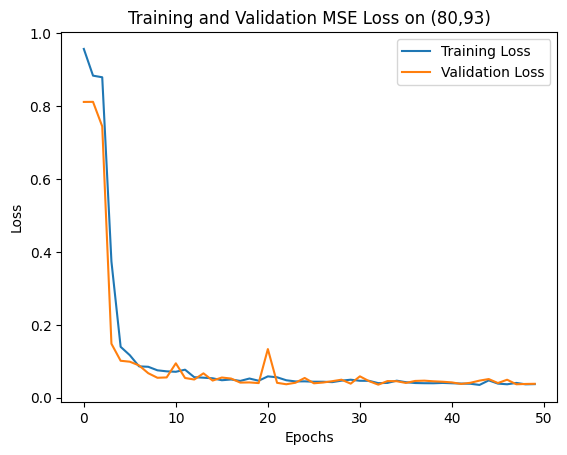

In [ ]:
# 繪製訓練和驗證損失曲線
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation MSE Loss on (80,93)')
plt.show()


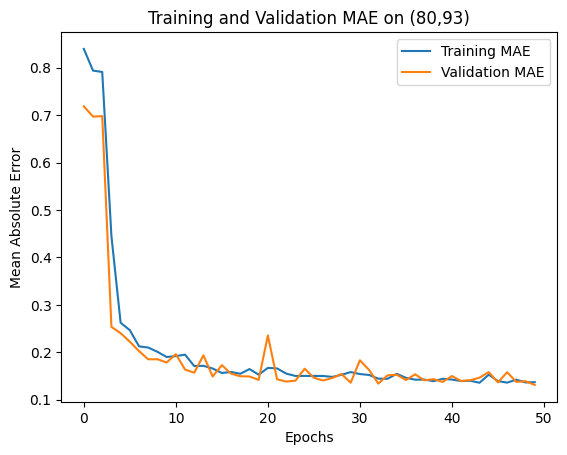

In [ ]:
# 繪製 MAE (Mean Absolute Error) 或 R2 等指標
train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE on (80,93)')
plt.show()


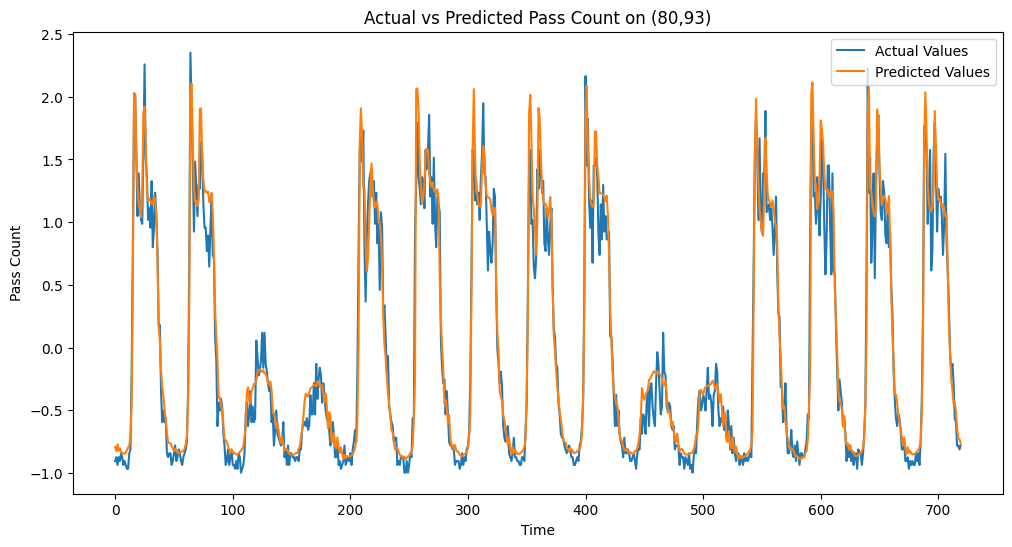

In [ ]:
# 調整圖片大小
plt.figure(figsize=(12, 6))

# 繪製預測值與實際值的比較
plt.plot(y_test, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Pass Count')
plt.legend()
plt.title('Actual vs Predicted Pass Count on (80,93)')
plt.show()


# 實作：80, 95

## 處理資料

In [ ]:
n_lag = 48

#獲取指定區塊的資料
df_80_95 = preprocess(df,80,95)

## 分割資料並建立配對資料
X_train, y_train = create_X_y_pairs(df_80_95, 0, 55, n_lag)
X_val, y_val = create_X_y_pairs(df_80_95, 55-1, 60, n_lag) # 第54天用來做X時間上的銜接，y不會被汙染
X_test, y_test = create_X_y_pairs(df_80_95, 60-1, 75, n_lag) # 第59天用來做X時間上的銜接，y不會被汙染

In [ ]:
X_train.shape

(2592, 480)

## 標準化
    僅處理人流部分、不更動時間與星期

In [ ]:
#train set

# 初始化 scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 對 count 部分標準化
X_count = X_train[:, :n_lag]  # 提取 count 部分
X_count = scaler_X.fit_transform(X_count)  # fit_transform 用於 count

# 替換原始的 count 部分
X_train[:, :n_lag] = X_count

# 對 y_train 使用 fit_transform 進行標準化
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

print(X_train.shape)
print(y_train.shape)

(2592, 480)
(2592,)


In [ ]:
#val set

# 對 count 部分標準化
X_count = X_val[:, :n_lag]  # 提取 count 部分
X_count = scaler_X.transform(X_count)  # transform 用於 count

# 替換原始的 count 部分
X_val[:, :n_lag] = X_count

# 對 y_val 使用 transform 進行標準化
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

print(X_val.shape)
print(y_val.shape)

(240, 480)
(240,)


In [ ]:
# test set

# 對 count 部分標準化
X_count = X_test[:, :n_lag]  # 提取 count 部分
X_count = scaler_X.transform(X_count)  # transform 用於 count

# 替換原始的 count 部分
X_test[:, :n_lag] = X_count

# 對 y_test 使用 transform 進行標準化
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(X_test.shape)
print(y_test.shape)

(720, 480)
(720,)


## 訓練

In [ ]:
# 重塑為LSTM所需的形狀 [樣本數, 時間步長, 特徵數]
X_train = X_train.reshape(X_train.shape[0], n_lag, 10)
X_val = X_val.reshape(X_val.shape[0], n_lag, 10)
X_test = X_test.reshape(X_test.shape[0], n_lag, 10)

# 建立LSTM模型
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])), # 默認激活為 tanh
    Dense(1)  # 預測當前時段的人流數量
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# 訓練模型並獲得訓練過程的歷史資料
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# 評估模型
loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9781 - mean_absolute_error: 0.8313 - val_loss: 0.9561 - val_mean_absolute_error: 0.8243
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9240 - mean_absolute_error: 0.8015 - val_loss: 0.9621 - val_mean_absolute_error: 0.8326
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9156 - mean_absolute_error: 0.7910 - val_loss: 0.3717 - val_mean_absolute_error: 0.4495
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2914 - mean_absolute_error: 0.4120 - val_loss: 0.1899 - val_mean_absolute_error: 0.3230
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2131 - mean_absolute_error: 0.3410 - val_loss: 0.1853 - val_mean_absolute_error: 0.3110
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1714 - mean_absolute_error: 0.3024 - val_loss: 0.1464 - val_mean_absolute_error: 0.2779
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1547 - mean_absolute_error: 0.2906 - val_loss: 0.1640 - val_mea

## 預測

In [ ]:
# 進行預測
y_pred = model.predict(X_test).flatten()  # 將預測結果轉為一維數組

# 計算均方誤差 (MSE)
test_loss = mean_squared_error(y_test, y_pred)
print(f'Prediction Loss: {test_loss}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Prediction Loss: 0.09403547061511544


## 視覺化分析

In [ ]:
# 提取訓練和驗證損失
train_loss = history.history['loss']
val_loss = history.history['val_loss']

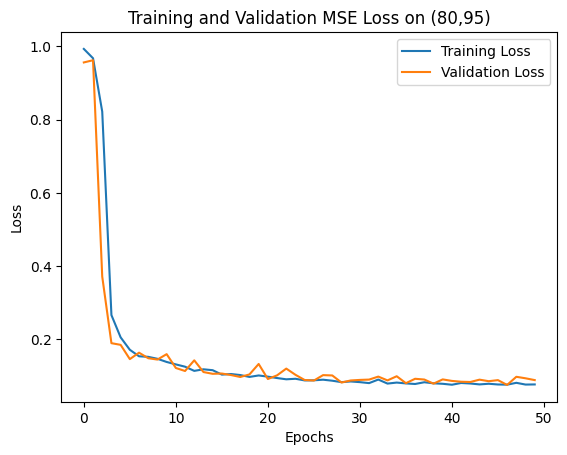

In [ ]:
# 繪製訓練和驗證損失曲線
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation MSE Loss on (80,95)')
plt.show()


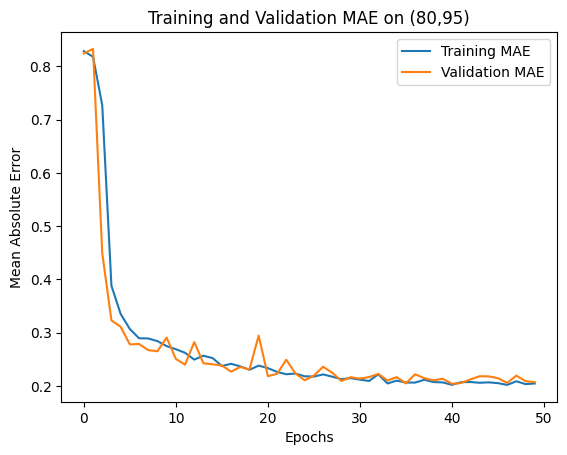

In [ ]:
# 繪製 MAE (Mean Absolute Error) 或 R2 等指標
train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE on (80,95)')
plt.show()


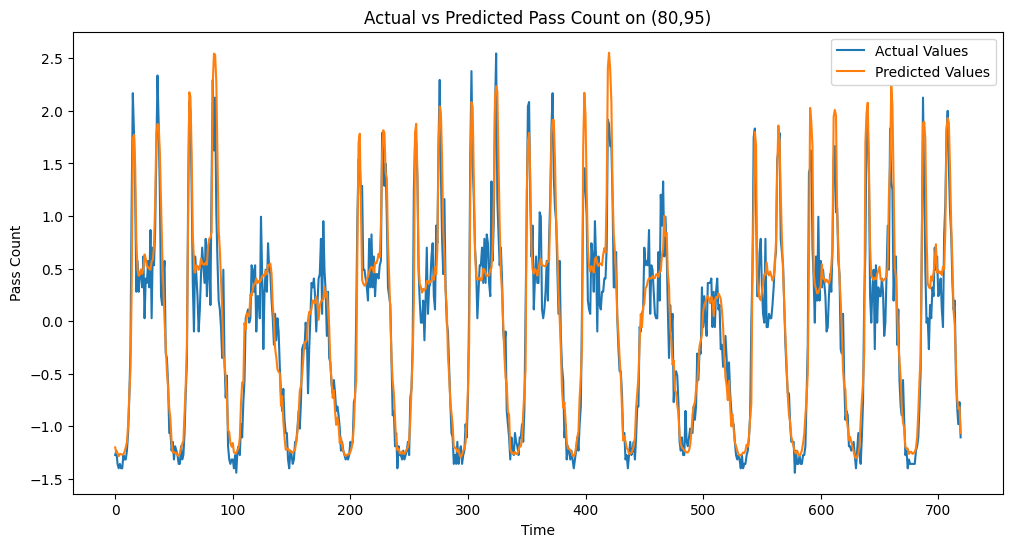

In [ ]:
# 調整圖片大小
plt.figure(figsize=(12, 6))

# 繪製預測值與實際值的比較
plt.plot(y_test, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Pass Count')
plt.legend()
plt.title('Actual vs Predicted Pass Count on (80,95)')
plt.show()


# 討論

1.三個區塊的val loss 皆略小於 train loss : 可能是val set略小、不足以表達導致的?

2.(80,93)區塊的預測對單個時段波動最準、loss也最小

3.(80,95)區塊的人流浮動較明顯，預測有較多誤差、loss也最大

4.三者皆捕捉到星期之間、日期之間以及單日內的周期訊息
